# Bull Call Spread on Bank Nifty Data

https://zerodha.com/varsity/chapter/bull-call-spread/

In this assignment I have given the code for bull call spread on bank nifty data for 1 month managing the delta of 0.8 <br/>
Also rather than buying at the money call option, we have bought bank nifty futures at the start of the month and we will hedge it by selling OTM call option.

## Importing important libraries

In [5]:
pip install py_vollib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# to fetch data 
import yfinance as yf

import scipy.stats as ss

import py_vollib.black_scholes.greeks.analytical as derivatives

import math

## Importing data

In [8]:
df_fut = pd.read_csv('/content/FUTIDX_BANKNIFTY_28-May-2021_TO_24-Jun-2021.csv')  #Fill in with the address of where you downloaded the file. You can check in properties of the file
df_fut.head()

,Symbol,Date,Expiry,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover in Lacs,Open Int,Change in OI,Underlying Value
0,BANKNIFTY,28-May-2021,24-Jun-2021,35499.00,35670.00,35150.00,35321.80,35394.05,35321.80,151658,1340811.02,1745000,27775,35141.45
1,BANKNIFTY,31-May-2021,24-Jun-2021,35280.00,35650.00,35063.15,35602.90,35578.25,35602.90,141916,1257088.18,1723450,-21550,-
2,BANKNIFTY,01-Jun-2021,24-Jun-2021,35677.95,35797.45,35313.95,35454.10,35470.00,35454.10,145631,1292727.92,1731125,7675,-
3,BANKNIFTY,02-Jun-2021,24-Jun-2021,35380.00,35560.00,35180.00,35524.25,35540.00,35524.25,113559,1003669.30,1700025,-31100,-
4,BANKNIFTY,03-Jun-2021,24-Jun-2021,35662.20,35890.00,35553.00,35781.95,35775.00,35781.95,121729,1086929.72,1690250,-9775,-


In [9]:
df_call_36000 = pd.read_csv('/content/OPTIDX_BANKNIFTY_CE_28-May-2021_TO_24-Jun-2021.csv')
df_call_36000.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover in Lacs,Premium Turnover in Lacs,Open Int,Change in OI,Underlying Value
0,BANKNIFTY,28-May-2021,24-Jun-2021,CE,36000,849.95,924.50,665.60,730.80,743.30,730.80,26704,245464.26,5128.26,320700,116225,35141.45
1,BANKNIFTY,31-May-2021,24-Jun-2021,CE,36000,693.90,790.00,598.10,772.95,752.05,772.95,19525,179242.57,3517.57,331150,10450,-
2,BANKNIFTY,01-Jun-2021,24-Jun-2021,CE,36000,782.00,832.00,633.35,660.65,661.00,660.65,31536,289503.11,5679.11,313700,-17450,-
3,BANKNIFTY,02-Jun-2021,24-Jun-2021,CE,36000,575.50,625.95,533.85,612.70,606.85,612.70,19060,174293.32,2753.32,324475,10775,-
4,BANKNIFTY,03-Jun-2021,24-Jun-2021,CE,36000,659.05,753.90,596.50,698.40,696.00,698.40,24549,225062.12,4121.12,328425,3950,-


In [10]:
symbol = '^NSEBANK'
end = '2021-06-25'
start = '2021-05-28'


# Read data 
df = yf.download(symbol,start,end)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-28,35345.648438,35436.648438,34977.199219,35141.449219,35141.449219,0
2021-05-31,35097.449219,35584.300781,34930.101562,35526.648438,35526.648438,0
2021-06-01,35639.750000,35713.898438,35241.199219,35337.199219,35337.199219,0
2021-06-02,35271.601562,35415.851562,35070.300781,35373.750000,35373.750000,0
2021-06-03,35536.449219,35723.699219,35413.000000,35649.000000,35649.000000,0


In [11]:
size = df.size

### Calculation of annual volatility and time remainig for expiry used in calculation of delta

In [12]:
symbol = '^NSEBANK'
end = '2021-05-28'
start = '2020-05-28'


# Read data 
#You need to read the from the files provided on NSE Bank for the time given above.

In [13]:
ret = df['Close'].pct_change()[1:]

In [14]:
ret.head()

Date
2021-05-31    0.010961
2021-06-01   -0.005333
2021-06-02    0.001034
2021-06-03    0.007781
2021-06-04   -0.010024
Name: Close, dtype: float64

In [15]:
daily_vol = ret.std()
daily_vol

0.007534349442956498

In [16]:
#calculate the Annual Volatility using the daily volatility given above.
ann_vol = daily_vol*np.sqrt(size)
ann_vol

0.08253466292067514

In [17]:
expiry = datetime.strptime('2021-06-24', '%Y-%m-%d')   #Expiry date

In [18]:
time = expiry-df.index    #Time left in days
df1 = pd.DataFrame(time)
df1.head()

,Date
0,27 days
1,24 days
2,23 days
3,22 days
4,21 days


In [19]:
#Convert Time left in days to int data type
t1 = df1["Date"].dt.days
t1

0     27
1     24
2     23
3     22
4     21
5     20
6     17
7     16
8     15
9     14
10    13
11    10
12     9
13     8
14     7
15     6
16     3
17     2
18     1
19     0
Name: Date, dtype: int64

### Initial buying and selling

In [20]:
no_of_lots_fut = 10           #number of future lots we bought at start of the month
buy_avg_future = df_fut['Open'][0]       #buying average of that lot
lot_size = 25     #lot size of bank nifty
delta = 1*no_of_lots_fut*lot_size    #taking delta of future is 1 as if banknifty changes by 1 the future would also change by 1
delta_to_maintain = 0.8*delta #Maintain 0.8 delta per future contract

In [32]:
flag = 'c'   #for call or put option
S = df['Open'][0]    #price of the underlying
K = 36000   #strike price
t = time[0]/365   #time left to expiry in years
sigma = ann_vol   #volatility
r = 0.06  #risk free rate
delta_per_lot_call = derivatives.delta(flag,df['Open'][0],K,t1[0],r,sigma) #Calculate delta per lot
delta_per_lot_call

0.9999607757999021

In [33]:
delta_to_maintain

200.0

In [34]:
delta

250

In [35]:
number_of_lots_call = math.ceil((delta-delta_to_maintain)/delta_per_lot_call)  #Calculate Number of call lots we have to sell to keep delta of 200

In [36]:
number_of_lots_call

51

In [37]:
sell_avg_call = df_call_36000['Open'][0]  #selling avg of call 
sell_avg_call

849.95

In [38]:
# Before moving on to managing delta, answer a few questions:

#Q1 : What do you think would happen to the delta of call option as banknifty goes up? (increase/decrease) 
#Ans : increase

#Q2 : So to manage the delta what would be done to call options already sold? (Buy some call options / Sell more) 
#Hint : Remember selling call options would give negative delta
#Ans : Buy some call options

### Managing delta

In [47]:
number_of_lots_call = math.ceil((delta-delta_to_maintain)/delta_per_lot_call)  #number of call lots we have to sell to keep delta of 200
sell_avg_call = df_call_36000['Open'][0]  #selling avg of call 
profit= []

for i in range(len(df)-1):
    delta_per_lot_call = derivatives.delta(flag,df['Open'][i],K,t1[i],r,sigma) #Calculate delta per lot at the next closing day
    current_number_of_lots_call = math.ceil((delta-delta_to_maintain)/delta_per_lot_call) #number of lots required to sell
    no_of_lots_added = current_number_of_lots_call #number of lots added/subtracted for selling
    sell_avg_call = df_call_36000['Open'][i]#new selling avg of call
    number_of_lots_call = number_of_lots_call + no_of_lots_added #update number of lots of calls sold
    profit.append((df_fut['Close'][i]-buy_avg_future)*no_of_lots_fut*lot_size + (sell_avg_call-df_call_36000['Close'][i])*lot_size*number_of_lots_call)  #unrealised profit 
    print(df_fut['Close'][i], buy_avg_future, sell_avg_call, df_call_36000['Close'][i])

35321.8 35499.0 849.95 730.8
35602.9 35499.0 693.9 772.95
35454.1 35499.0 782.0 660.65
35524.25 35499.0 575.5 612.7
35781.95 35499.0 659.05 698.4
35508.5 35499.0 677.1 549.15
35622.2 35499.0 563.0 537.05
35265.3 35499.0 501.95 349.15
34929.35 35499.0 330.7 234.7
35266.35 35499.0 218.95 306.15
35169.35 35499.0 352.7 242.95
35065.1 35499.0 192.6 172.55
35330.4 35499.0 176.35 203.7
35101.35 35499.0 177.25 145.05
34682.2 35499.0 86.95 55.9
34596.75 35499.0 57.3 32.05
34911.1 35499.0 28.0 25.65
34775.8 35499.0 64.05 14.7
34611.9 35499.0 19.9 8.1


In [41]:
#As you can see that the number of lots of call sold is way too many as the delta of out of money call option approches 0 in the end
#Thus this strategy would practically be possible by changing the strike price of the call option as it goes deep out of money
#But that would require much higher level programming thats why we have given this simple assignment jst theoretically make
#you realise the power of hedging
number_of_lots_call

1070

In [48]:
sell_avg_call

19.9

In [43]:
delta_per_lot_call

0.6540801117252579

In [44]:
profit

[259532.50000000096,
 -276391.24999999994,
 607659.9999999998,
 -230837.5000000003,
 -230290.0000000009,
 1144328.7500000002,
 295489.99999999977,
 1694955.000000001,
 1081587.4999999995,
 -1281142.5000000002,
 1596762.4999999995,
 223853.74999999936,
 -530347.4999999995,
 516412.49999999953,
 429996.2499999994,
 323625.0,
 -92278.75000000032,
 1044313.7500000005,
 93875.00000000035]

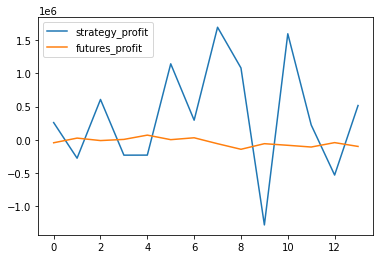

In [45]:
plt.plot(profit[:14], label = 'strategy_profit')
plt.plot((df_fut['Close']-df_fut['Open'][0])[:14]*250, label = 'futures_profit')
plt.legend()

As you can see from the above graph of first first 14 days of the strategy that though the futures did fall very down but<br/>
We were able to hedge this with selling of call option and our strategy did give better returns overall<br/>
<br/>
We didnt plot the whole graph as in the end many lots of call options were sold which is practically not possible<br/>